In [209]:
import torch
import matplotlib.pyplot
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

In [210]:
ds = torchvision.datasets.CIFAR10('./', download=True, transform=torchvision.transforms.ToTensor())
x, y = ds[1]
x.shape

Files already downloaded and verified


torch.Size([3, 32, 32])

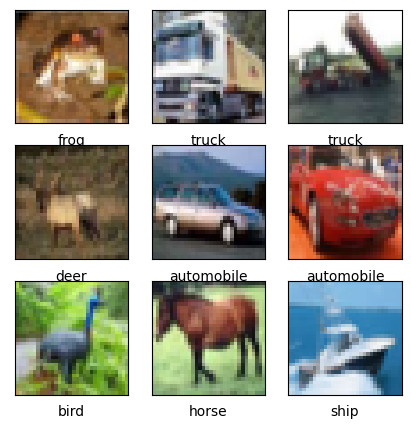

In [316]:
# show a 9x9 grid of images example from dataset ds, with text labels
plt.figure(figsize=(5,5))
for i in range(3*3):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(ds[i][0].permute(1, 2, 0))
    plt.xlabel(ds.classes[ds[i][1]])

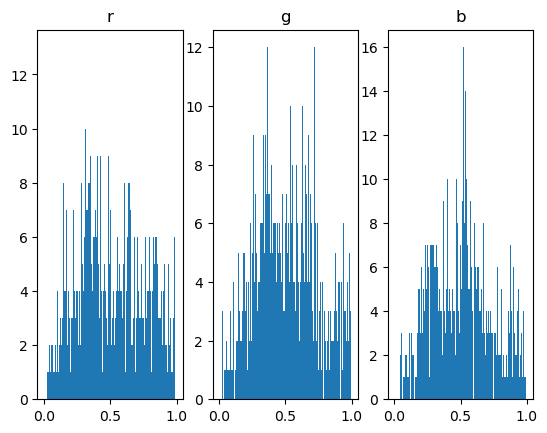

In [212]:
x, y = ds[1]
for c in range(3):
    xc = x[c]
    plt.subplot(1, 3, c+1)
    plt.hist(xc.ravel(), bins=256, range=(0.0, 1.0));
    plt.title(["r", "g", "b"][c])

In [213]:
x[0].min(), x[0].max()

(tensor(0.0196), tensor(0.9961))

In [214]:
# y: (B)  yh: (B)

y = torch.tensor([1, 2, 3, 4])
yh = torch.tensor([1, 0, 0, 0])

def accuracy(y, yh):
    return (y == yh).float().mean()

accuracy(y, yh)

tensor(0.2500)

In [215]:
train_ds, valid_ds = torch.utils.data.random_split(ds, [0.9, 0.1], generator=torch.Generator())
len(train_ds), len(valid_ds)

(45000, 5000)

In [153]:
@torch.no_grad()
def eval_split(split, model, samples=None):
    batch_size = 256
    ds = train_ds if split == "train" else valid_ds
    dl = torch.utils.data.DataLoader(ds, batch_size=256, shuffle=True, generator=torch.Generator())
    lossi = []
    acci = []

    for i, (xb, yb) in enumerate(dl):
        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        lossi.append(loss.item())
        
        prob = F.softmax(logits, dim=1) # (B, 10)
        yh = torch.argmax(prob, dim=1) # (B)
        acc = accuracy(yh, yb)
        acci.append(acc.item())

        if samples and i * batch_size > samples:
            break

    return torch.tensor(lossi).mean(), torch.tensor(acci).mean()

In [427]:
class MLP(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        gain = nn.init.calculate_gain('tanh') 

        self.linear1 = nn.Linear(32*32*3, 1024)
        # nn.init.kaiming_normal_(self.linear1.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.linear1.weight, gain)

        self.linear2 = nn.Linear(1024, 512)
        # nn.init.kaiming_normal_(self.linear2.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.linear2.weight, gain)

        self.linear3 = nn.Linear(512, 256)
        # nn.init.kaiming_normal_(self.linear3.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.linear3.weight, gain)

        self.linear4 = nn.Linear(256, 10)
        self.linear4.bias = nn.Parameter(torch.zeros_like(self.linear4.bias))
        self.h = [0] * 5

    
    # x: (B, 3, 32, 32)
    # y: (B, 10)
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        self.h[0] = x

        x = self.linear1(x).tanh()
        self.h[1] = x

        x = self.linear2(x).tanh()
        self.h[2] = x

        x = self.linear3(x).tanh()
        self.h[3] = x

        x = self.linear4(x)
        self.h[4] = x

        return x

model = MLP()
sum([p.numel() for p in model.parameters()])

3805450

## Experiement

In [352]:
a = nn.Linear(32*32*3, 1024)
nn.init.kaiming_normal_(a.weight, nonlinearity='relu')
a.weight.mean(), a.weight.std(), a.bias.mean(), a.bias.std()

(tensor(7.7353e-06, grad_fn=<MeanBackward0>),
 tensor(0.0255, grad_fn=<StdBackward0>),
 tensor(0.0002, grad_fn=<MeanBackward0>),
 tensor(0.0100, grad_fn=<StdBackward0>))

In [349]:
torch.tensor(2).sqrt() / torch.tensor(32*32*3).sqrt()

tensor(0.0255)

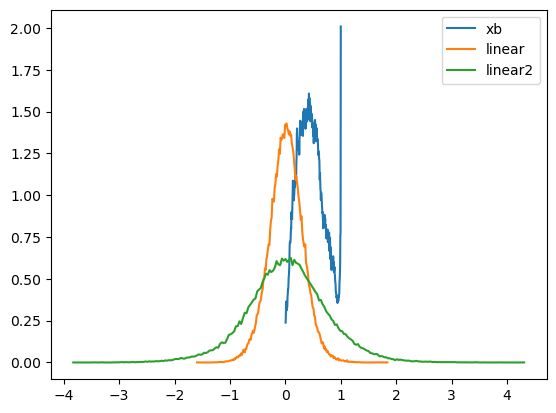

In [331]:
dl = torch.utils.data.DataLoader(train_ds, batch_size=128)
xb, yb = next(iter(dl))


xb = xb.view(-1, 32*32*3)
val, axis = xb.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="xb")

linear1 = nn.Linear(32*32*3, 1024)
linear1.requires_grad_(False)
a = linear1(xb)
val, axis = a.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="linear")


linear2 = nn.Linear(32*32*3, 1024)
linear2.requires_grad_(False)
nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
a = linear2(xb)
val, axis = a.histogram(density=True, bins=256)
plt.plot(axis[1:], val, label="linear2")

plt.legend()

## Sanity Check

Check if model has the capacity of overfit a small batch

In [428]:
model = MLP()
dl = torch.utils.data.DataLoader(train_ds, batch_size=10)
optimizer = torch.optim.Adam(model.parameters())
xb, yb = next(iter(dl))

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"{loss.item():.4f}")

2.3754
0.0025
0.0012
0.0007
0.0005
0.0004
0.0003
0.0002
0.0002
0.0002


Initial loss check

In [431]:
model = MLP()
dl = torch.utils.data.DataLoader(train_ds, batch_size=512)
xb, yb = next(iter(dl))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("loss:", loss.item())
print("chance:", -torch.tensor(1/10).log().item())

loss: 2.378859519958496
chance: 2.3025851249694824


Activation distribution check

layer 0: mean +0.48, std 0.25, zero: 0.11%
layer 1: mean +0.01, std 0.64, zero: 0.00%
layer 2: mean -0.01, std 0.69, zero: 0.00%
layer 3: mean -0.05, std 0.71, zero: 0.00%
layer 4: mean +0.03, std 0.35, zero: 0.00%


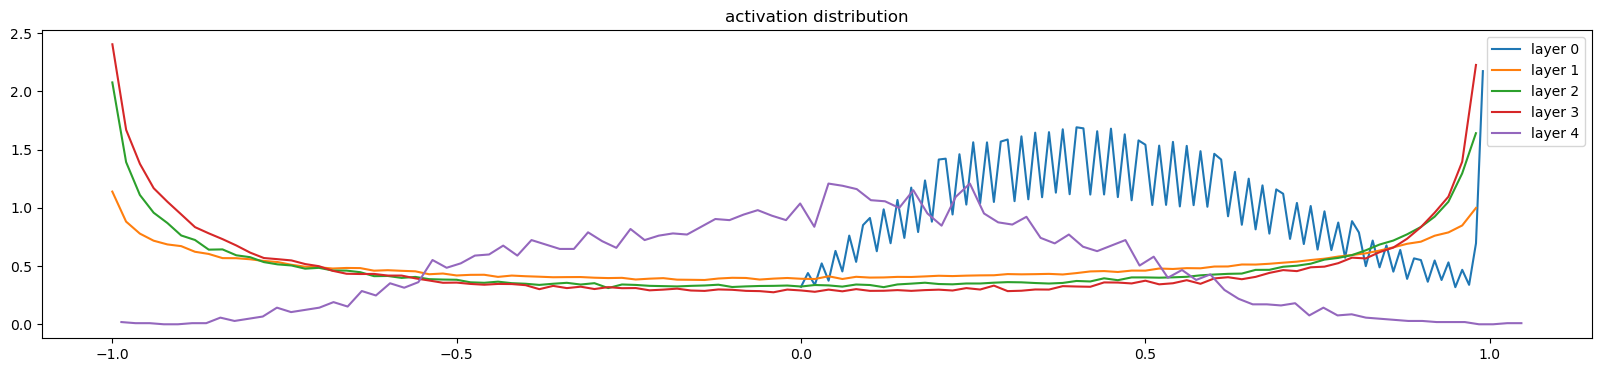

In [432]:
plt.figure(figsize=(20, 4))
legends = []
for i, t in enumerate(model.h):
    print('layer %d: mean %+.2f, std %.2f, zero: %.2f%%' % (i, t.mean(), t.std(), (t.abs() == 0).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

layer 0: mean -0.00, std 0.00, zero: 14.17%
layer 1: mean +0.00, std 0.00, zero: 14.48%
layer 2: mean +0.00, std 0.00, zero: 10.79%
layer 3: mean -0.00, std 0.02, zero: 0.39%


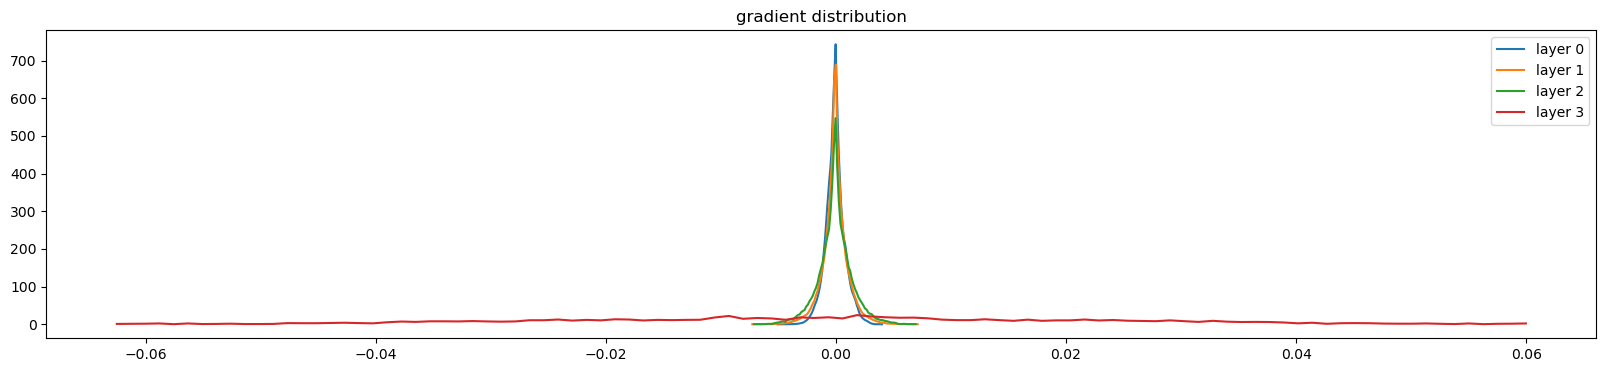

In [433]:
plt.figure(figsize=(20, 4))
legends = []
layers = [model.linear1, model.linear2, model.linear3, model.linear4]

for i, l in enumerate(layers):
    t = l.weight.grad
    print('layer %d: mean %+.2f, std %.2f, zero: %.2f%%' % (i, t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('gradient distribution');

## Training

In [434]:
model = MLP()

In [441]:
dl = torch.utils.data.DataLoader(train_ds, batch_size=32)
lr = 0.005
epoch = 1
i = 0
n = len(dl) * epoch

metrics = []
update_ratio = []
optimizer = torch.optim.SGD(model.parameters(), lr)

for _ in range(epoch):
    for xb, yb in dl:
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)

        loss.backward()
        
        if i % 100 == 0:
            tr_loss, tr_acc = eval_split("train", model, samples=1000)
            va_loss, va_acc = eval_split("valid", model, samples=1000)
            print(f"{i/n:.2f}: {tr_loss:.4f} {tr_acc:.4f} {va_loss:.4f} {va_acc:.4f}")
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))

            r = [(-lr*p.grad).std() / p.std() for p in model.parameters() if p.dim() == 2]
            update_ratio.append(r)

        i += 1
        optimizer.step()

0.00: 2.3631 0.1258 2.3708 0.1187
2 0.0002444437996018678 0.0002444519195705652
1 0.0017258153529837728 0.0017258357256650925
2 0.00020048447186127305 0.0002004836278501898
1 0.0010240123374387622 0.001023801858536899
2 0.0001859124458860606 0.00018591605476103723
1 0.000878170772921294 0.0008841375820338726
2 0.006998881231993437 0.006998430006206036
1 inf inf


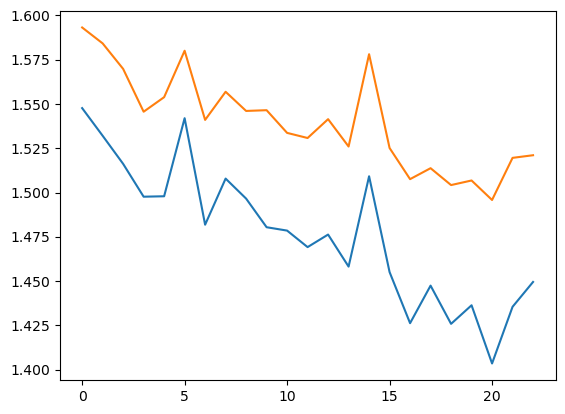

In [319]:
# plot loss and accuracy, one on left and another on the right
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)
plt.plot(tr_loss, label="tr_loss")
plt.plot(va_loss, label="va_loss")

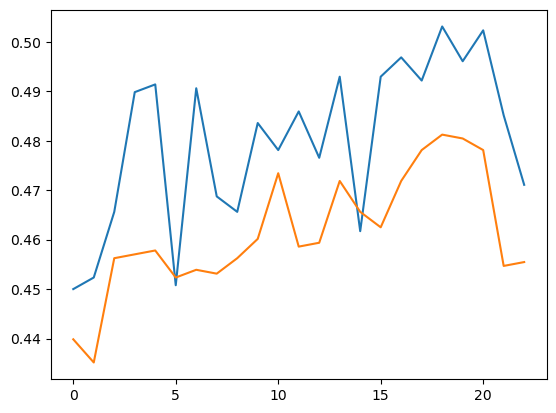

In [320]:
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)
plt.plot(tr_acc, label="tr_acc")
plt.plot(va_acc, label="va_acc")

In [369]:
@torch.no_grad()
def predict(x):
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    return yh

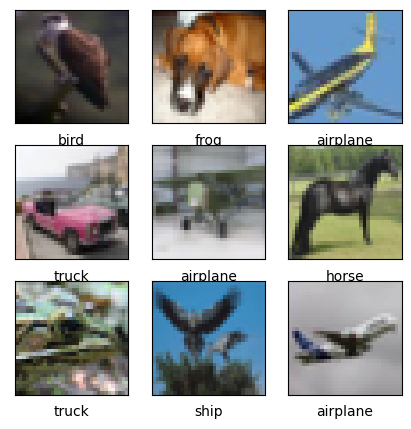

In [373]:
dl = torch.utils.data.DataLoader(valid_ds, batch_size=9, shuffle=True)
x, y = next(iter(dl))
yh = predict(x)

plt.figure(figsize=(5,5))
for i in range(3*3):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i].permute(1, 2, 0))
    plt.xlabel(ds.classes[yh[i]])